# 毕业项目：检测分神司机

In [51]:
%config InlineBackend.figure_format = 'retina'

from urllib.request import urlretrieve
from os.path import isfile, isdir, join, pardir
from IPython.display import SVG, Image
import random
import glob
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.utils import to_categorical

import pydot
import cv2
import h5py

### 一、数据探索

driver_img_list.csv列出了训练集中的司机id，类别id和图像文件名称。10个类别id如下：
- c0: 安全驾驶
- c1: 右手打字
- c2: 右手打电话
- c3: 左手打字
- c4: 左手打电话
- c5: 调收音机
- c6: 喝饮料
- c7: 拿后面的东西
- c8: 整理头发和化妆
- c9: 和其他乘客说话

查看每个类别包含的图像数量。

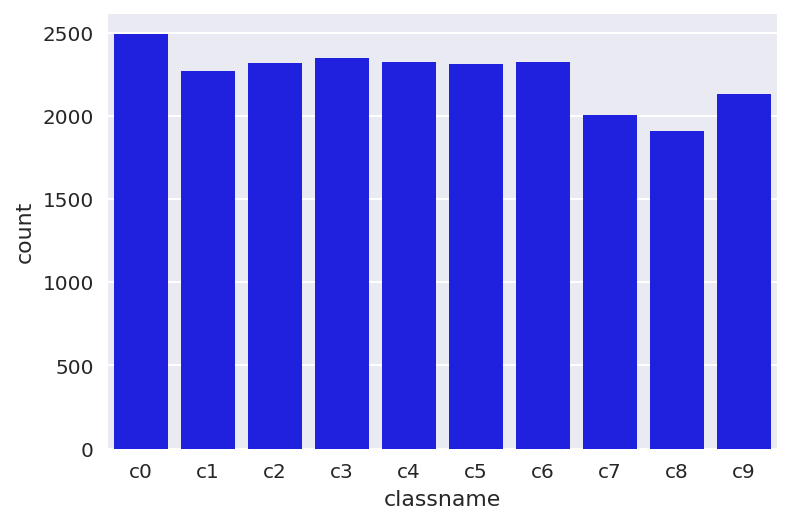

In [2]:
driver_image_list = pd.read_csv(join(pardir, 'data', 'driver_imgs_list.csv'))

sns.set(style="darkgrid")
ax = sns.countplot(x='classname', data=driver_image_list, color='blue')

每个司机拥有的图像数量。

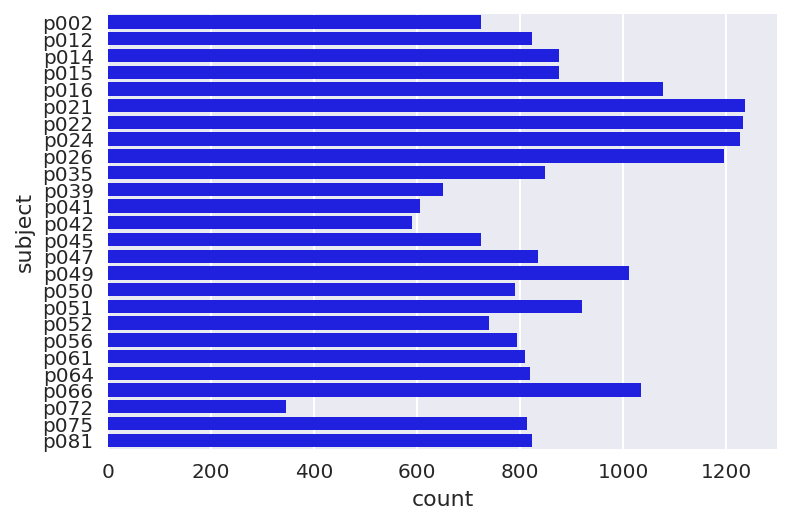

In [3]:
ax = sns.countplot(y='subject', data=driver_image_list, color='blue')

每个司机在每个类别上的图像数量分布。

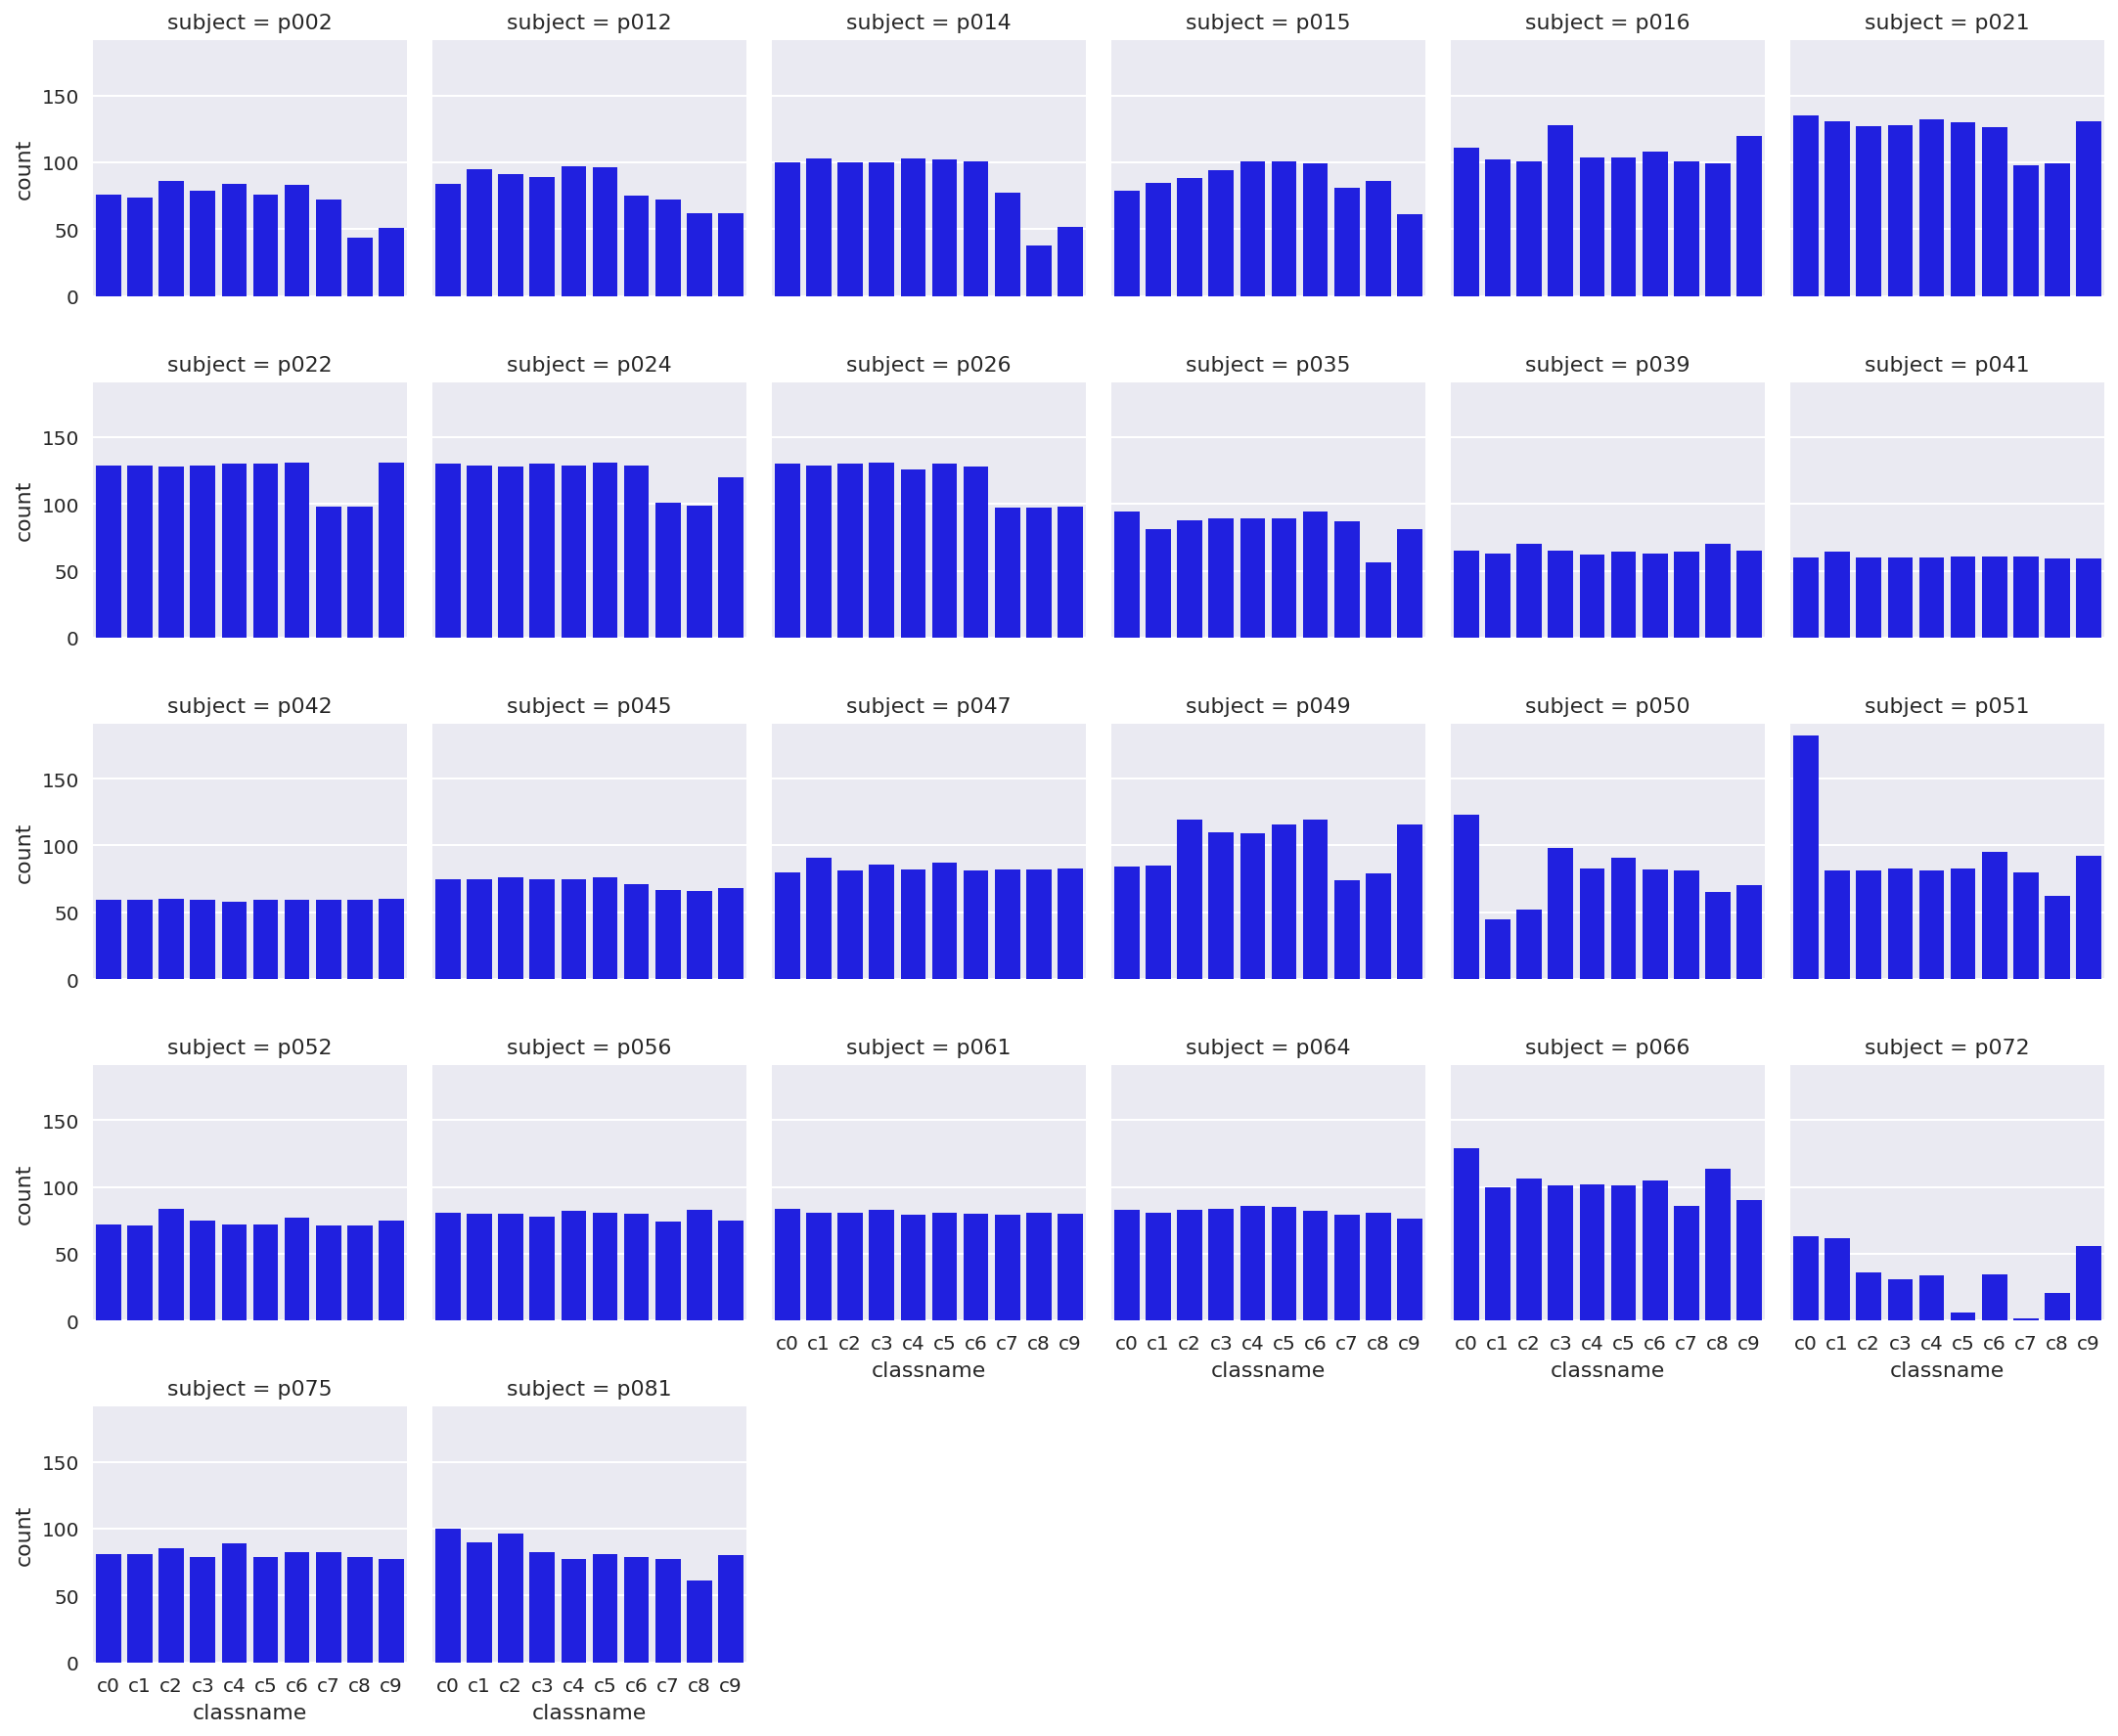

In [4]:
ax = sns.factorplot(x="classname", col='subject', col_wrap=6, data=driver_image_list, kind="count", size=2.5, color='blue')

In [5]:
driver_dataset_folder_path = join(pardir, 'data', 'driver_dataset')
zip_path = join(pardir, 'data', 'imgs.zip')

# 解压图像数据压缩包
if not isdir(driver_dataset_folder_path):
    with zipfile.ZipFile(zip_path) as zipfile:
        zipfile.extractall(driver_dataset_folder_path)
        zipfile.close()

查看单张图像文件。

The size of the image is (480, 640, 3):


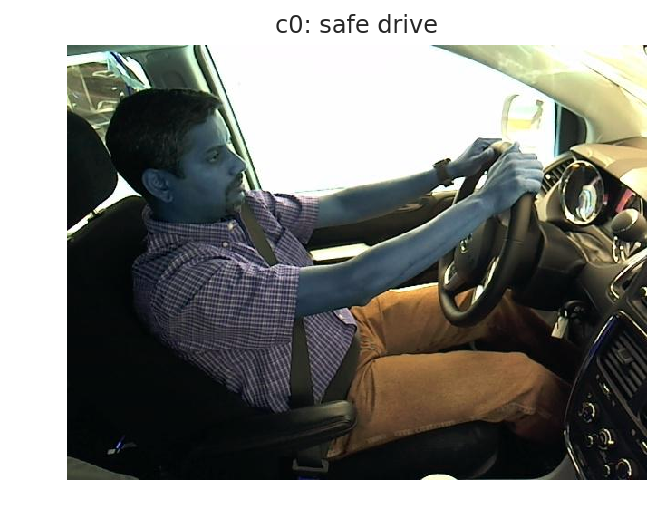

resize the size of the image to 224*224.
The size of the image is (224, 224, 3):


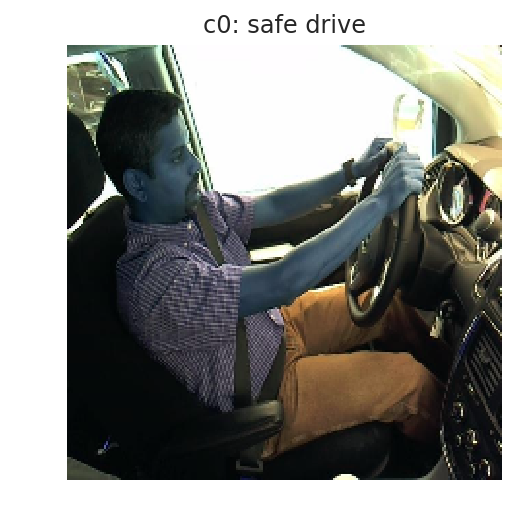

In [6]:
image_train_folder_path = join(pardir, 'data', 'driver_dataset', 'train')
image_test_floder_path = join(pardir, 'data', 'driver_dataset', 'test')

# 示例图片
image_file = join(image_train_folder_path, 'c0', 'img_34.jpg')
image = cv2.imread(image_file)

print("The size of the image is {}:".format(image.shape))
plt.axis('off')
plt.title("c0: safe drive")
plt.imshow(image)
plt.show()

print("resize the size of the image to 224*224.")
resized = cv2.resize(image, (224, 224))
print("The size of the image is {}:".format(resized.shape))
plt.axis('off')
plt.title("c0: safe drive")
plt.imshow(resized)
plt.show()

### 二、数据集预处理

训练集数据加载

In [9]:
# vgg16模型图像数据大小固定为224*224
image_size = 224
X = []
y = []
for i in range(10):
    image_path = join(driver_dataset_folder_path, 'train', 'c%s'%i)
    images = glob.glob(join(image_path, '*.jpg'))
    print('loading {}, image count={}'.format(image_path, len(images)))
    for image_file in images:
        image = cv2.imread(image_file)
        X.append(cv2.resize(image, (image_size, image_size)))
        y.append(i)
X = np.array(X)
y = np.array(y)
y = to_categorical(y, num_classes=10)
print('loading complete!')
print(X.shape)
print(y.shape)
print(y[0])
print(y[1])

loading ../data/driver_dataset/train/c0, image count=2489
loading ../data/driver_dataset/train/c1, image count=2267
loading ../data/driver_dataset/train/c2, image count=2317
loading ../data/driver_dataset/train/c3, image count=2346
loading ../data/driver_dataset/train/c4, image count=2326
loading ../data/driver_dataset/train/c5, image count=2312
loading ../data/driver_dataset/train/c6, image count=2325
loading ../data/driver_dataset/train/c7, image count=2002
loading ../data/driver_dataset/train/c8, image count=1911
loading ../data/driver_dataset/train/c9, image count=2129
loading complete!
(22424, 224, 224, 3)
(22424, 10)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=33)
print("训练集数据大小：")
print(X_train.shape, y_train.shape)
print("验证集数据大小：")
print(X_valid.shape, y_train.shape)

训练集数据大小：
(15696, 224, 224, 3) (15696, 10)
验证集数据大小：
(6728, 224, 224, 3) (15696, 10)


### 二、创建基准模型

In [36]:
def create_model_vgg16():
    model_vgg16 = VGG16(include_top=False, weights='imagenet')
    
    print('Print vgg16 model summary:')
    print(model_vgg16.summary())
    
    for layer in model_vgg16.layers:
        layer.trainable = False

    input = Input(shape=(224, 224, 3), name='image_input')

    output_vgg16_conv = model_vgg16(input)
    
    x = GlobalAveragePooling2D()(output_vgg16_conv)
    
    #x = Flatten()(x)
    
    x = Dropout(0.5)(x)
    
    x = Dense(10, activation='softmax')(x)

    model = Model(inputs=input, outputs=x)

    model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

### 三、基准模型可视化

Print vgg16 model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 1

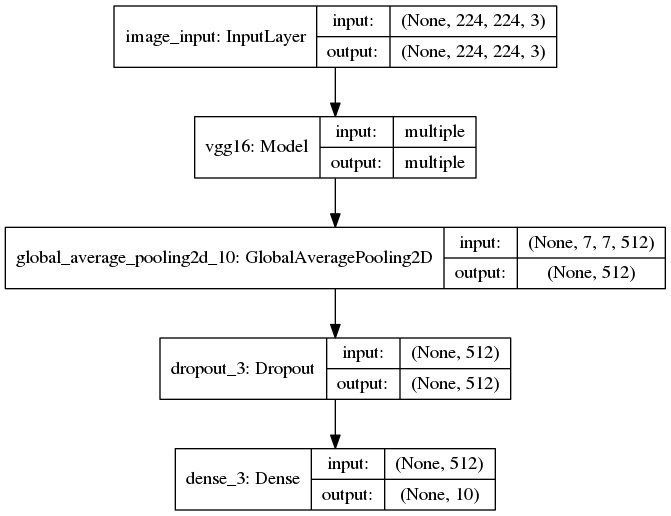

In [37]:
model = create_model_vgg16()
print('Print my model summry:')
print(model.summary())
plot_model(model, show_shapes=True)
Image('model.png')

### 五、基准模型训练

In [39]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_valid, y_valid))
model.save("vgg16.h5")

Train on 15696 samples, validate on 6728 samples
Epoch 1/10
15696/15696 [==============================] - 249s 16ms/step - loss: 5.6550 - acc: 0.3188 - val_loss: 1.3494 - val_acc: 0.6364
Epoch 2/10
15696/15696 [==============================] - 243s 15ms/step - loss: 2.1228 - acc: 0.5357 - val_loss: 0.5140 - val_acc: 0.8392
Epoch 3/10
15696/15696 [==============================] - 241s 15ms/step - loss: 1.5068 - acc: 0.6023 - val_loss: 0.3795 - val_acc: 0.8873
Epoch 4/10
15696/15696 [==============================] - 241s 15ms/step - loss: 1.3214 - acc: 0.6223 - val_loss: 0.5504 - val_acc: 0.8309
Epoch 5/10
15696/15696 [==============================] - 244s 16ms/step - loss: 1.2572 - acc: 0.6305 - val_loss: 0.4738 - val_acc: 0.8579
Epoch 6/10
15696/15696 [==============================] - 242s 15ms/step - loss: 1.2156 - acc: 0.6348 - val_loss: 0.4723 - val_acc: 0.8546
Epoch 7/10
15696/15696 [==============================] - 242s 15ms/step - loss: 1.2025 - acc: 0.6339 - val_loss: 0.5

### 六、基准模型评估

In [43]:
X_test = []
test_image_path = join(driver_dataset_folder_path, 'test')
images = glob.glob(join(test_image_path, '*.jpg'))
count = 0
for image_file in images:
    image = cv2.imread(image_file)
    X_test.append(cv2.resize(image, (224, 224)))
    count += 1
    if count == 1000:
        break
    
print("Test images loaded.")
X_test = np.array(X_test)
print(X_test.shape)

Test images loaded.
(1000, 224, 224, 3)


In [44]:
model = load_model("vgg16.h5")
#predict(self, x, batch_size=None, verbose=0, steps=None)
pred = model.predict(X_test, batch_size=16, verbose=1)

1000/1000 [==============================] - 12s 12ms/step


In [45]:
pred.shape

(1000, 10)

In [46]:
#pd.DataFrame(pred).to_csv("prediction.csv")

In [47]:
#pred = pd.read_csv("prediction.csv")

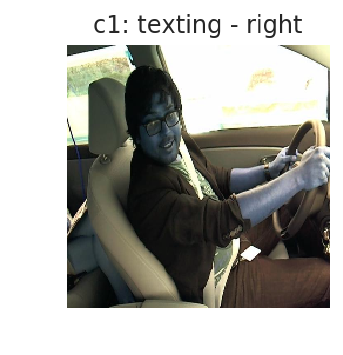

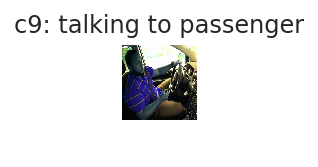

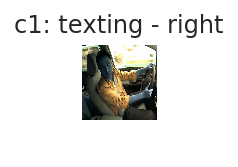

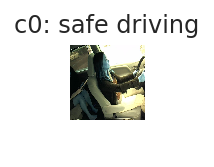

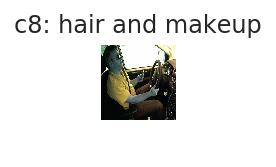

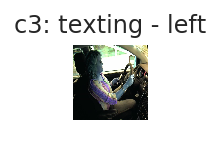

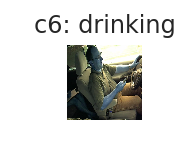

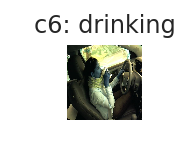

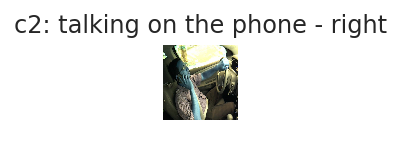

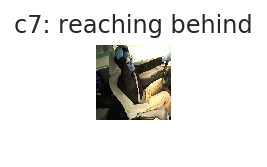

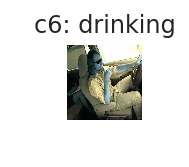

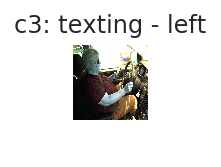

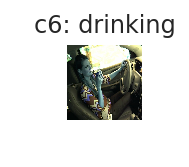

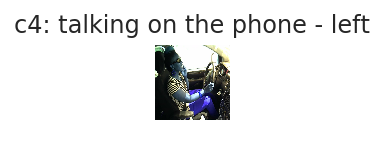

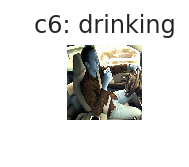

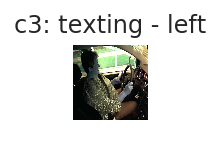

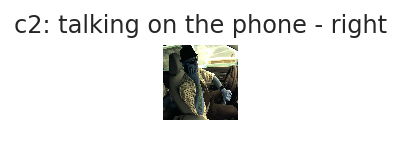

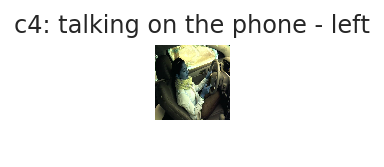

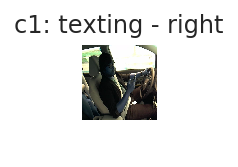

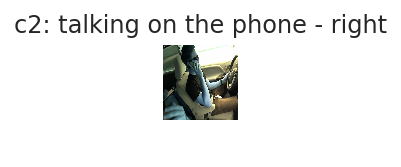

In [63]:
classes = []

descs = ['safe driving', 
        'texting - right', 
        'talking on the phone - right', 
        'texting - left', 
        'talking on the phone - left',
        'operating the radio',
        'drinking',
        'reaching behind',
        'hair and makeup',
        'talking to passenger']

for i in pred:
    max_idx = np.argmax(i)
    classes.append(max_idx)

plt.figure(figsize=(12, 14))
for i in range(20):
    plt.subplot(5, 4, i+1)
    idx = random.randint(0,1000)
    plt.axis('off')
    plt.title("c{}: {}".format(classes[idx], descs[classes[idx]]))
    plt.imshow(X_test[idx])
    plt.show()